<a href="https://colab.research.google.com/github/yingzibu/MOL2ADMET/blob/main/embedding/GIN_embedding_test_M5_UMAP_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print(torch.__version__)
print('cuda: ', torch.cuda.is_available())

2.1.0+cu121
cuda:  True


In [ ]:
! pip install rdkit --quiet
! pip install PyTDC --quiet
! pip install mycolorpy --quiet
! pip install selfies  --quiet
! pip install pubchempy --quiet
! pip install dgllife --quiet
! pip install molvs --quiet
! pip install umap-learn --quiet
! pip install dgl -f https://data.dgl.ai/wheels/cu121/repo.html --quiet
! pip install dglgo -f https://data.dgl.ai/wheels-test/repo.html --quiet
! pip install DeepPurpose --quiet
! pip install git+https://github.com/bp-kelley/descriptastorus --quiet
! pip install pandas-flavor --quiet

In [1]:
cd /content/drive/MyDrive/ADMET

/content/drive/MyDrive/ADMET


In [2]:
from scripts.func_utils import make_path, convert_with_qed_sa, get_min, \
                                plot_loss, plot_performance

from scripts.eval_utils import *
from scripts.preprocess_mols import *
from scripts.model_architecture import *
from scripts.dataset import *
from scripts.train import *
import yaml
import pandas as pd
from scripts.get_vocab import *

from tdc.single_pred import ADME
from tdc.single_pred import Tox
from scripts.CONSTANT import *
from scripts.yaml_utils import *
from scripts.TRAIN import *
print('VOCAB TYPE:', VOCAB_TYPE)

VOCAB TYPE: smiles


In [ ]:
clean_files()

removed from /content/drive/MyDrive/ADMET/: gin_supervised_contextpred_pre_trained.pth 


In [3]:
from IPython.display import Code

Code(filename='scripts/model_architecture.py', language='python')

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
# print(os.getcwd()) 
import time
import pandas as pd
import dgl
from torch.utils.data import DataLoader
from dgllife.model import model_zoo, load_pretrained
from dgllife.utils import smiles_to_bigraph, EarlyStopping, Meter
from dgllife.utils import PretrainAtomFeaturizer, PretrainBondFeaturizer
from dgllife.utils import AttentiveFPAtomFeaturizer, AttentiveFPBondFeaturizer
from dgllife.data import MoleculeCSVDataset
from dgllife.model.gnn import AttentiveFPGNN
from dgllife.model.readout import AttentiveFPReadout
from dgl.nn.pytorch.glob import AvgPooling
from torch.utils.data import Dataset, DataLoader
from functools import partial
from transformers import AutoModelWithLMHead, AutoTokenizer

from scripts.CONSTANT import MASK, MACCS_LEN
# from scripts.train import get_loss_fn
from scripts.get_vocab import get_c2i_i2c
from scripts.dataset import get_rnn_loader

def get_loss_fn(IS_R):
    if IS_R: return nn.MSELoss(reduction='sum')
    else: return nn.BCEWithLogitsLoss(reduction='sum')

class Classifier(nn.Module):
    def __init__(self, **config):
        super(Classifier, self).__init__()
        dims = [config['in_dim'], config['hid_dims'], config['out_dim']]
        self.dims = dims
        neurons = [config['in_dim'], *config['hid_dims']]
        linear_layers = [nn.Linear(neurons[i-1], neurons[i]) \
                         for i in range(1, len(neurons))]
        self.hidden = nn.ModuleList(linear_layers)
        self.final = nn.Linear(config['hid_dims'][-1], config['out_dim'])
        self.dropout = nn.Dropout(config['dropout'])
        self.model_type = config['model_type']

    def forward(self, x):
        # for MUE: 
        ensemble_here = False
        if len(x.shape) == 3:
            ensemble_here = True
            batch_size, num_tasks, num_models = x.shape
            x = x.view(-1, num_models) 
        for layer in self.hidden: x = F.relu(layer(x))
        x = self.dropout(x)
        x = self.final(x)
        if ensemble_here == True: x = x.view(batch_size, num_tasks)
        return x

    # def forward(self, x, y=None, IS_R=None, return_pred=True):
    #     for layer in self.hidden: x = F.relu(layer(x))
    #     x = self.dropout(x)
    #     x = self.final(x)
    #     if return_pred: return x
    #     if y != None and IS_R != None:
    #         mask = y == MASK
    #         weight_loss = [1/len(IS_R)] * len(IS_R)
    #     else: print('Error, need provide label and IS_R'); return
    #     for j, (is_r, w) in enumerate(zip(IS_R, weight_loss)):
    #         loss_func = get_loss_fn(is_r)
    #         probs = x[:,j][~mask[:,j]]
    #         label = y[:,j][~mask[:,j]]
    #         len_here = label.shape[0]
    #         loss_here = loss_func(probs, label)
    #         if len_here != 0:
    #             loss_here /= len_here
    #         if j == 0: loss = loss_here * w
    #         else: loss += loss_here * w
    #     # classify_loss  = loss_func(x[~mask], y[~mask])
    #     return x, loss


    def get_dim(self): return self.dims


def get_model_AT_10_17(names, n_layers, graph_feat_size, num_timesteps, dropout):
    atom_featurizer = AttentiveFPAtomFeaturizer(atom_data_field='hv')
    bond_featurizer = AttentiveFPBondFeaturizer(bond_data_field='he')
    n_feats_num = atom_featurizer.feat_size('hv')
    e_feats_num = bond_featurizer.feat_size('he')

    model = model_zoo.AttentiveFPPredictor(
            node_feat_size=n_feats_num, edge_feat_size=e_feats_num,
            num_layers=n_layers, num_timesteps=num_timesteps,
            graph_feat_size=graph_feat_size,
            n_tasks=len(names), dropout=dropout)
    
    return model

def AttentiveFP(**config):
    model =   get_model_AT_10_17(config['prop_names'], config['n_layers'],
    config['graph_feat_size'], config['num_timesteps'], config['dropout'])
    model.model_type = config['model_type']
    return model

# https://lifesci.dgl.ai/_modules/dgllife/model/pretra

## comparison between ST and MT

In [ ]:
folder_name = 'M5/uw_no'
for model_type in ['MLP', 'AttentiveFP', 'GIN', 'RNN']:
    perfs = []

    for i in range(3):
        file_name = f'{folder_name}/{model_type}_MT_{i}.yml'
        p = yml_report(file_name)
        perfs.append(p)

    for name in names_M5:
        perfs_ST = []
        for j in range(3):
            file_name = f'ST/{name}/{model_type}_ST_{j}.yml'
            p = yml_report(file_name)
            perfs_ST.append(p)
        print('#'*35, model_type, '#'*35)
        print('*'*20, 'ST', '*'*20)
        eval_perf_list(perfs_ST, name, {'cls': [0,1,6,8], 'reg':[0,2,3]})
        print('*'*20, 'MT', '*'*20)
        eval_perf_list(perfs, name, {'cls': [0,1,6,8], 'reg':[0,2,3]})
        print('\n\n')

################################### MLP ###################################
******************** ST ********************
repeated num # 3 idx 2 has the lowest loss
******************** CYP2C19_Veith ******************** 
	|       acc      |       w_acc      |       auc      |       ap      
	&0.780$\pm$0.004  &0.780$\pm$0.004  &0.853$\pm$0.003  &0.806$\pm$0.004  
 idx 2: &0.785            &0.784            &0.854            &0.805            

******************** MT ********************
repeated num # 3 idx 2 has the lowest loss
******************** CYP2C19_Veith ******************** 
	|       acc      |       w_acc      |       auc      |       ap      
	&0.801$\pm$0.004  &0.800$\pm$0.003  &0.871$\pm$0.006  &0.839$\pm$0.012  
 idx 2: &0.807            &0.805            &0.879            &0.856            




################################### MLP ###################################
******************** ST ********************
repeated num # 3 idx 1 has the lowest loss
*************

### Check MT-GIN model

In [ ]:
Code('scripts/model_architecture.py')

In [4]:
# file_name = f'{folder_name}/{model_type}_MT_{i}.yml'
file_name = 'M5/uw_no/GIN_MT_1.yml'
names = names_M5
import yaml
with open(file_name, 'r') as f: data = yaml.safe_load(f)
config = data['config']
models = PRED(**config)
trn, val, tst = collect_data(names)
trn_l, val_l, tst_l, vocab = get_multi_loader(trn, val, tst, config)

gin_supervised_contextpred_pre_trained.pth:   0%|          | 0.00/7.45M [00:00<?, ?B/s]

Pretrained model loaded
Model type:  GIN | Model parameters:  1978801


Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!


collect data for:  ['CYP2C19_Veith', 'CYP2D6_Veith', 'CYP3A4_Veith', 'CYP1A2_Veith', 'CYP2C9_Veith']


Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!


---> loader for ['CYP2C19_Veith', 'CYP2D6_Veith', 'CYP3A4_Veith', 'CYP1A2_Veith', 'CYP2C9_Veith']
--> preparing data loader for model type  GIN
--> preparing data loader for model type  GIN
--> preparing data loader for model type  GIN


# calculate embedding from MT-GIN

In [5]:
config

{'IS_R': [False, False, False, False, False],
 'MAX_EPOCH': 600,
 'batch_size': 128,
 'config_path': 'M5/uw_no/GIN_MT_1.yml',
 'dropout': 0.1,
 'hid_dims': [128, 64, 32, 16],
 'in_dim': 256,
 'lr': 0.0001,
 'model_path': 'M5/uw_no/GIN_MT_1.pt',
 'model_type': 'GIN',
 'out_dim': 5,
 'patience': 30,
 'pretrain_model': 'gin_supervised_contextpred',
 'prop_names': ['CYP2C19_Veith',
  'CYP2D6_Veith',
  'CYP3A4_Veith',
  'CYP1A2_Veith',
  'CYP2C9_Veith'],
 'scale_dict': None,
 'uncertainty_weight': False,
 'verbose_freq': 100,
 'wd': 1e-05,
 'weight_loss': [0.2, 0.2, 0.2, 0.2, 0.2]}

In [6]:
from tqdm import tqdm
models.model.eval()
embs = None
mu_dict = {}
y_label = {}
# tqdm(enumerate(tst_l), total=len(tst_l), desc='Cal Emb')
for idx, batch_data in tqdm(enumerate(tst_l), total=len(tst_l), desc='Cal Emb'):
    fp, labels = batch_data
    # labels = labels.to(config)
    # print(labels.shape)
    mu = models.model(fp.to('cuda'), return_emb=True)
    # print('emb shape', emb.shape)
    labels = labels.to('cuda')
    mask = labels == MASK
    for j, (name, is_r) in enumerate(zip(config['prop_names'], config['IS_R'])):
        mask_here = mask[:,j]
        label = labels[:,j][~mask_here]
        # mask_here = mask_here.reshape(mask_here.shape[0],1).expand_as(mu)
        # mu_ = mu * (~mask_here)
        unmask_indices = torch.nonzero(1-mask_here.float().squeeze(),
                                       as_tuple=False).squeeze()
        mu_ = mu[unmask_indices]
        # print(label.shape, mu_.embs.shape[0]shape)
        if label.shape[0] != mu_.shape[0]:
            print(label.shape, mu_.shape, 'different! ')
            mu_ = mu_.reshape(label.shape[0], mu_.shape[0])
        # break
    # break
    #     break
    # break

        del mask_here
        label = label.cpu().detach().numpy().tolist()
        mu_ = mu_.cpu().detach().numpy()
        # print(mu_.shape)
        if idx == 0:
            mu_dict[name] = mu_
            y_label[name] = label
        else:
            mu_dict[name] = np.append(mu_dict[name], mu_.copy(), axis=0).copy()
            y_label[name] += label
        assert len(y_label[name]) == mu_dict[name].shape[0]
        # print(len(y_label[name]), mu_dict[name].shape)
    #     break
    # break

#     # print(emb, emb.shape)
#     emb = emb.cpu().detach().numpy()

#     if idx == 0: embs = emb.copy()
#     else: embs = np.concatenate((embs, emb), axis=0).copy()
#     # print(embs.shape)
#     # if idx == 3: break
#     # embs += emb
#     # break
# assert len(tst_l.dataset) ==

Cal Emb: 100%|██████████| 73/73 [00:20<00:00,  3.63it/s]


In [7]:
# ! pip install umap-learn --quiet

import umap
def plot_dim_reduced(mol_info, label, task_type, dim_reduct='PCA',
                     title=None, savepath=None, savename=None, ver=False,
                     plot_show=True, cp=None):
    """
    param mol_info: could be MACCS Fingerprint
    param label: label of data
    param task_type: [True, False], True:regression; False: classification
    param dim_reduct" : ['PCA', 't-SNE', 'UMAP']
    param title: None or string, the name of the plot
    param cp:    color palette
    Return figure.png saved at dim_reduct/title.png
    """
    import umap

    features, labels = mol_info.copy(), label.copy()
    n_components = 2
    if dim_reduct == 'PCA':
        pca = PCA(n_components=n_components)
        pca.fit(features)
        features = StandardScaler().fit_transform(features)
        features = pd.DataFrame(data=pca.transform(features))
        ax_label = 'principle component'
    elif dim_reduct == 't-SNE':
        features = TSNE(n_components=n_components).fit_transform(features)
        features = MinMaxScaler().fit_transform(features)
        features = pd.DataFrame(np.transpose((features[:,0],features[:,1])))
        ax_label = 't-SNE'
    elif dim_reduct == 'UMAP':
        umap_reducer = umap.UMAP(n_components=n_components)
        features = umap_reducer.fit_transform(features)
        features = pd.DataFrame(np.transpose((features[:,0],features[:,1])))
        ax_label = 'UMAP'
    else:
        print("""Error! dim_reduct should be 'PCA', 't-SNE', or 'UMAP'""")
        return

    columns = [f'{ax_label} {i+1}' for i in range(n_components)]
    features.columns = columns
    features['label'] = labels

    sns.set_theme(style="whitegrid")
    f, ax = plt.subplots()

    if task_type == False:
        # palette_type = 'vlag'
        if cp == None: palette_type = 'vlag'
        else: palette_type = cp
    else:
        palette_type = 'RdBu'
    param_dict = {'x': columns[0],
                  'y': columns[1],
                  'hue': 'label',
                  'palette': palette_type,
                  'data': features,
                  's': 10,
                  'ax': ax}

    sns.scatterplot(**param_dict)

    if task_type == True:
        norm = plt.Normalize(labels.min(), labels.max())
        scalarmap = plt.cm.ScalarMappable(cmap=param_dict['palette'], norm=norm)
        scalarmap.set_array([])
        ax.figure.colorbar(scalarmap)
        ax.get_legend().remove()
    else:
        sns.move_legend(ax, 'upper right')

    ax = plt.gca()
    border_color = 'black'
    border_width = 0.6

    for i in ['top', 'right', 'bottom', 'left']:
        ax.spines[i].set_visible(True)

    for spine in ax.spines.values():
        spine.set_linewidth(border_width)
        spine.set_color(border_color)

    if title == None:
        title = f'{dim_reduct}_demo'
    plt.title(title)
    if savepath != None:
        make_path(savepath, False)
        if savename == None:
            savename = f'{savepath}/{title}.png'
        else:
            savename = savepath + '/' + savename
        plt.savefig(savename, format='png', transparent=False)
        if ver:
            print(f'figure saved at {savename}')
    if plot_show:
        plt.show()
    plt.close()

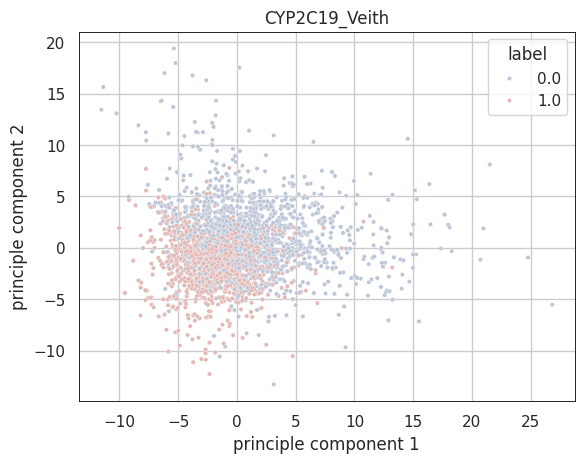

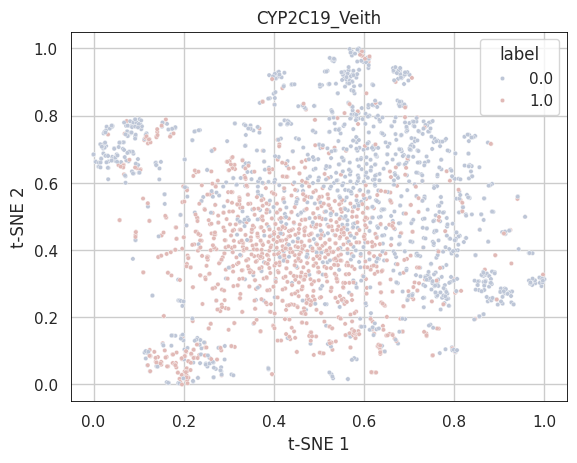

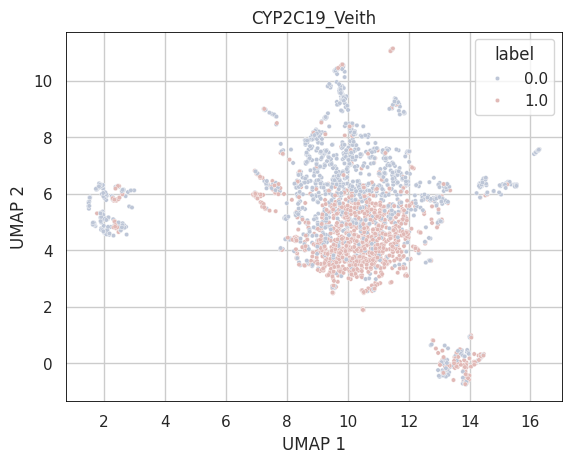

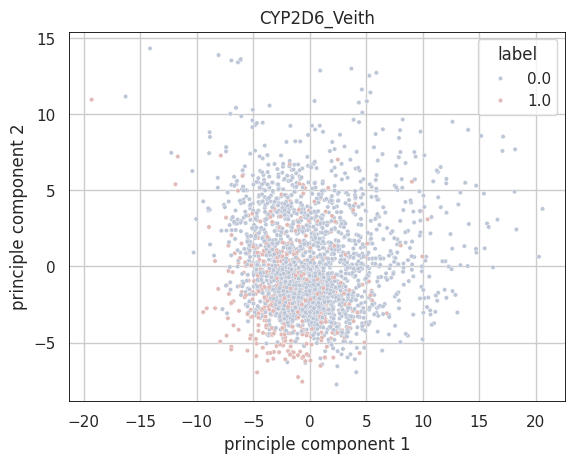

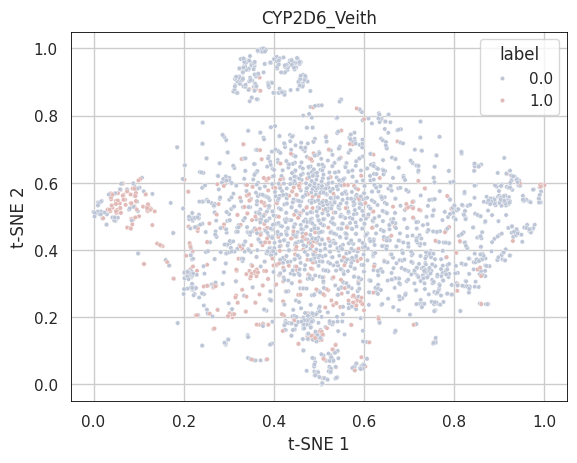

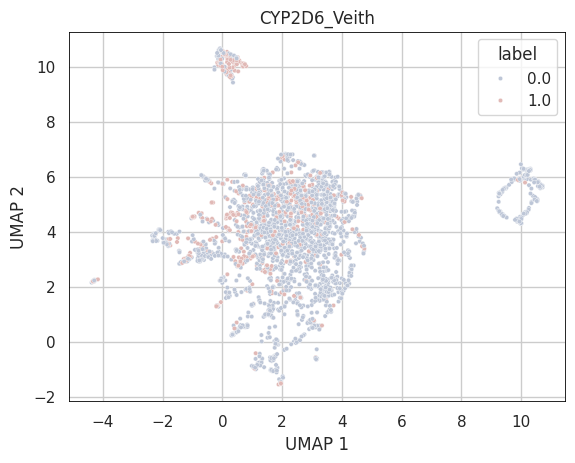

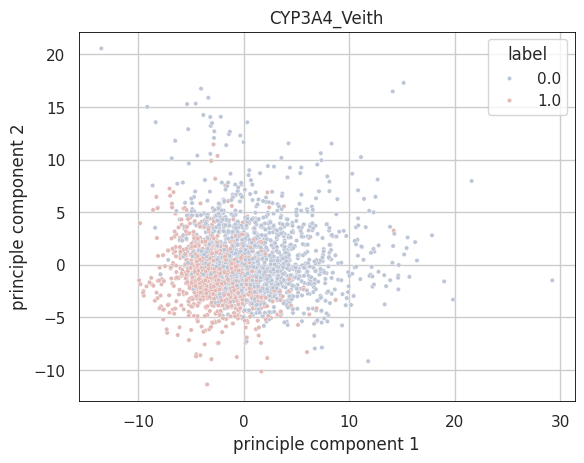

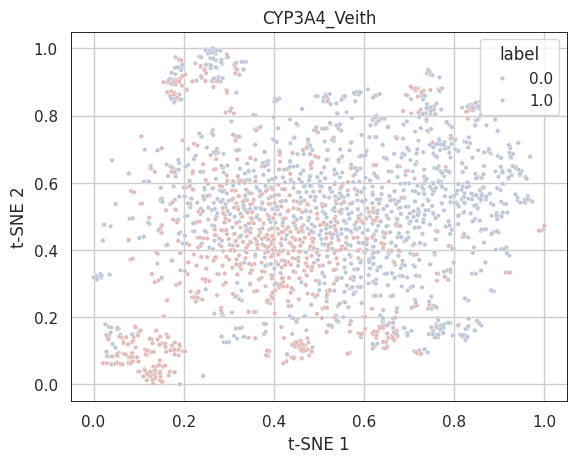

KeyboardInterrupt: 

In [8]:
for name in names:
    for dim_reduct in ['PCA', 't-SNE', 'UMAP']:
        plot_dim_reduced(mu_dict[name], np.array(y_label[name]), names_dict[name],
                         dim_reduct=dim_reduct, title=f'{name}', cp=None)


(2533, 16)


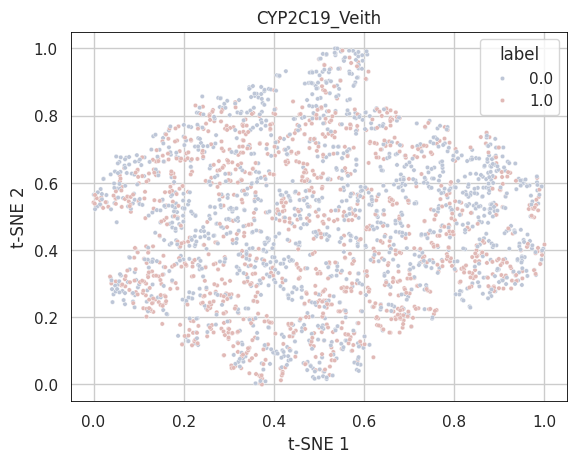

(2626, 16)


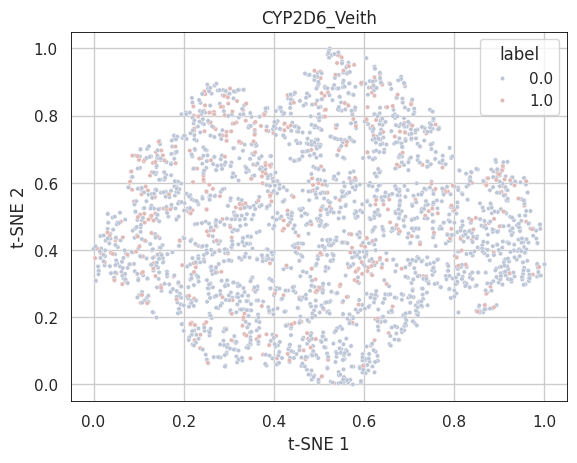

(2466, 16)


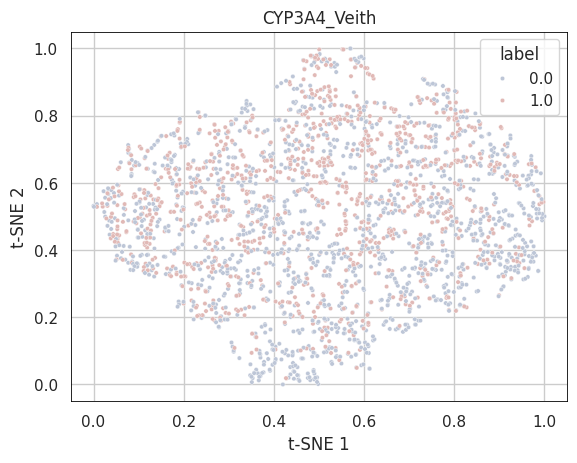

(2516, 16)


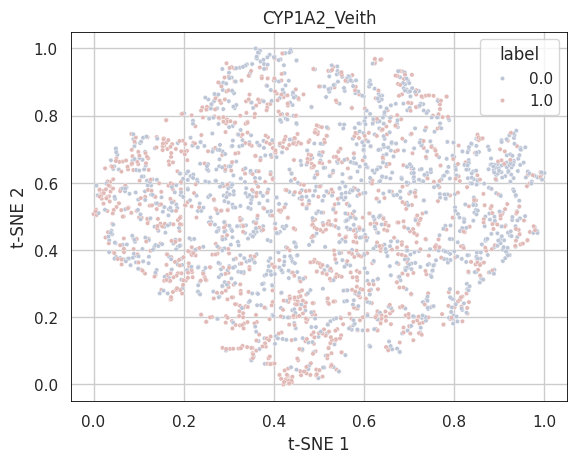

(2418, 16)


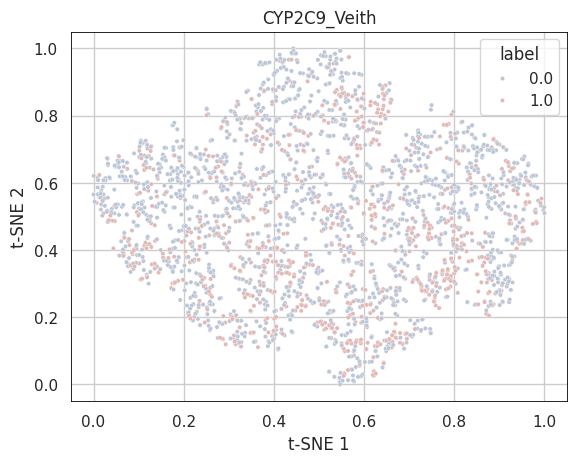

In [ ]:
# tst_df = tst.fillna(-100)
# name = names_M5[0]
# tst_df[name].tolist()[-1]
# for name in names_M5:
#     label_all = tst_df[name].tolist()
#     unmask_inds = []; label = []
#     for idx in range(len(embs)):
#         if label_all[idx] != MASK:
#             unmask_inds.append(idx); label.append(label_all[idx])
#     features = embs[unmask_inds, :]
#     print(features.shape)
#     plot_dim_reduced(features, label, names_dict[name], dim_reduct='t-SNE', title=f'{name}')

In [9]:
file_name = 'M5/uw/GIN_MT_1.yml'
names = names_M5
import yaml
with open(file_name, 'r') as f: data = yaml.safe_load(f)
config = data['config']
models = PRED(**config)

gin_supervised_contextpred_pre_trained.pth:   0%|          | 0.00/7.45M [00:00<?, ?B/s]

Pretrained model loaded
Model type:  GIN | Model parameters:  1978801


In [10]:
from tqdm import tqdm
models.model.eval()
embs = None
mu_dict = {}
y_label = {}
# tqdm(enumerate(tst_l), total=len(tst_l), desc='Cal Emb')
for idx, batch_data in tqdm(enumerate(tst_l), total=len(tst_l), desc='Cal Emb'):
    fp, labels = batch_data
    # labels = labels.to(config)
    # print(labels.shape)
    mu = models.model(fp.to('cuda'), return_emb=True)
    # print('emb shape', emb.shape)
    labels = labels.to('cuda')
    mask = labels == MASK
    for j, (name, is_r) in enumerate(zip(config['prop_names'], config['IS_R'])):
        mask_here = mask[:,j]
        label = labels[:,j][~mask_here]
        # mask_here = mask_here.reshape(mask_here.shape[0],1).expand_as(mu)
        # mu_ = mu * (~mask_here)
        unmask_indices = torch.nonzero(1-mask_here.float().squeeze(),
                                       as_tuple=False).squeeze()
        mu_ = mu[unmask_indices]
        # print(label.shape, mu_.embs.shape[0]shape)
        if label.shape[0] != mu_.shape[0]:
            print(label.shape, mu_.shape, 'different! ')
            mu_ = mu_.reshape(label.shape[0], mu_.shape[0])


        del mask_here
        label = label.cpu().detach().numpy().tolist()
        mu_ = mu_.cpu().detach().numpy()
        # print(mu_.shape)
        if idx == 0:
            mu_dict[name] = mu_
            y_label[name] = label
        else:
            mu_dict[name] = np.append(mu_dict[name], mu_.copy(), axis=0).copy()
            y_label[name] += label
        assert len(y_label[name]) == mu_dict[name].shape[0]


Cal Emb: 100%|██████████| 73/73 [00:20<00:00,  3.61it/s]


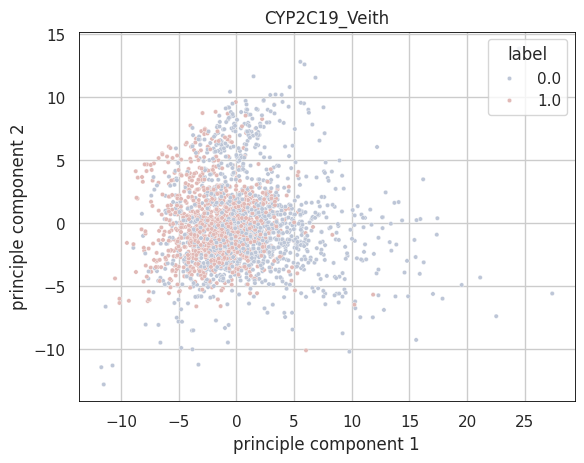

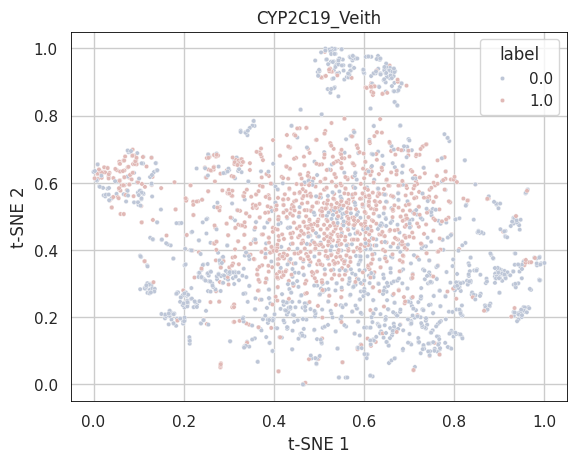

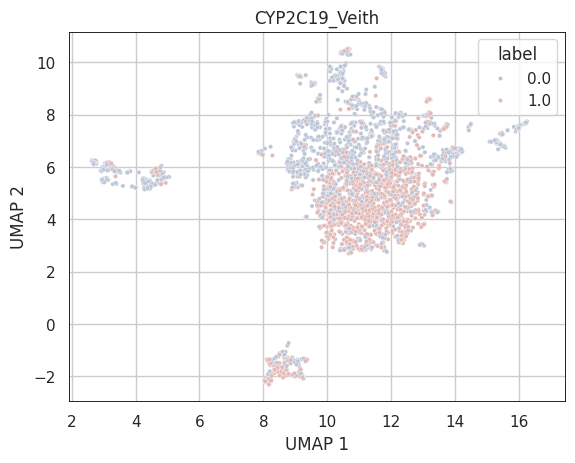

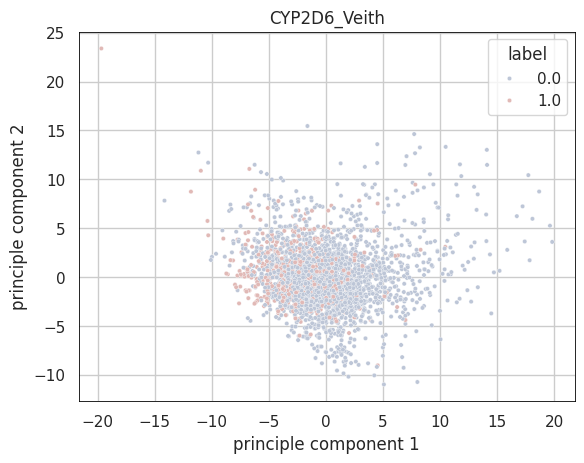

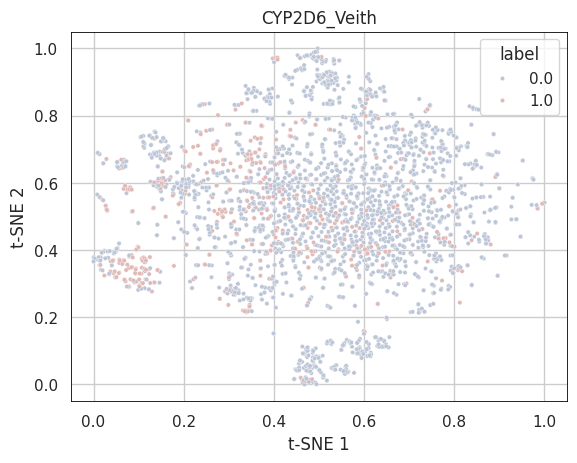

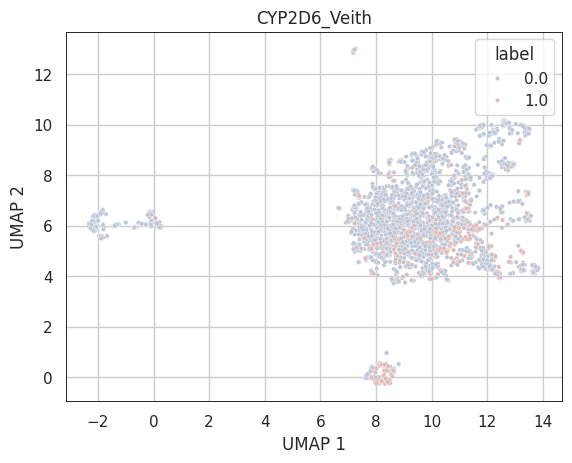

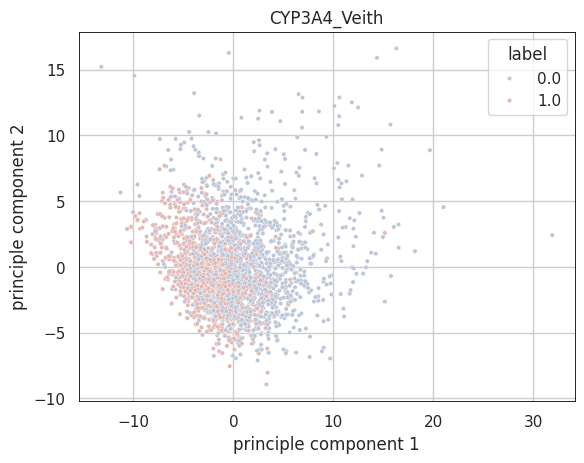

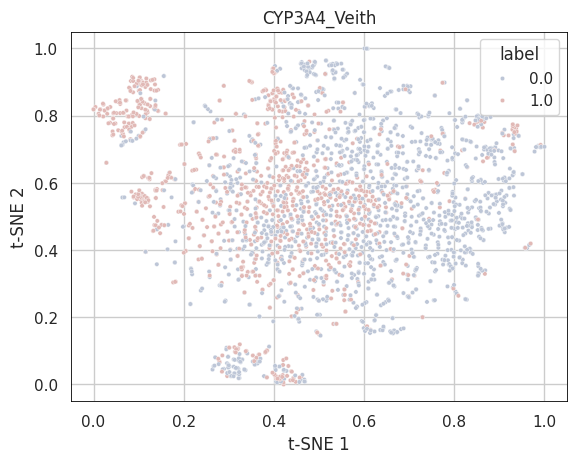

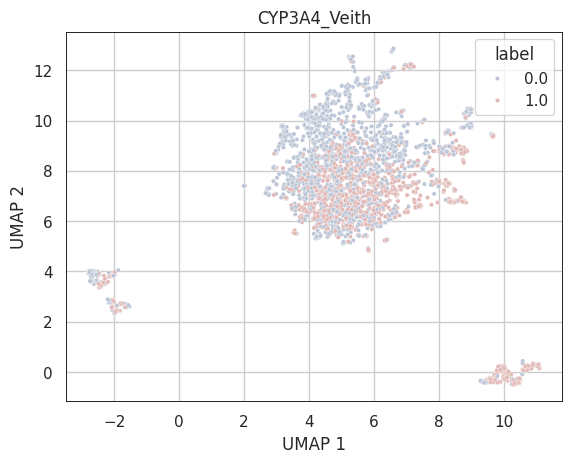

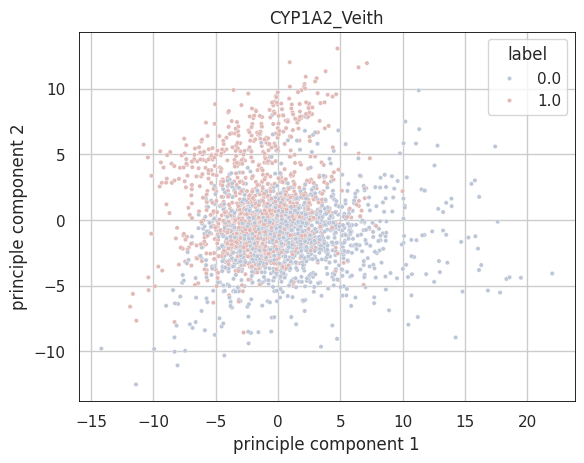

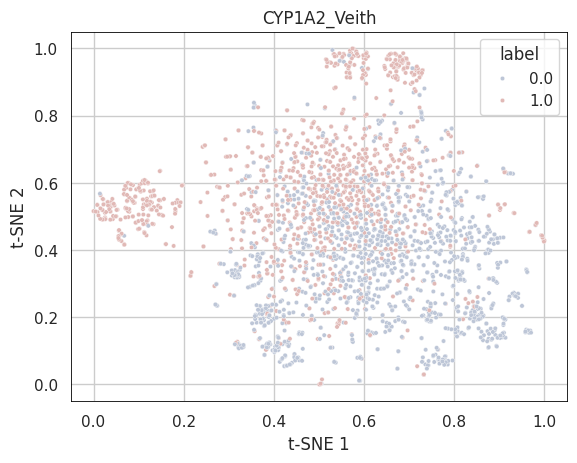

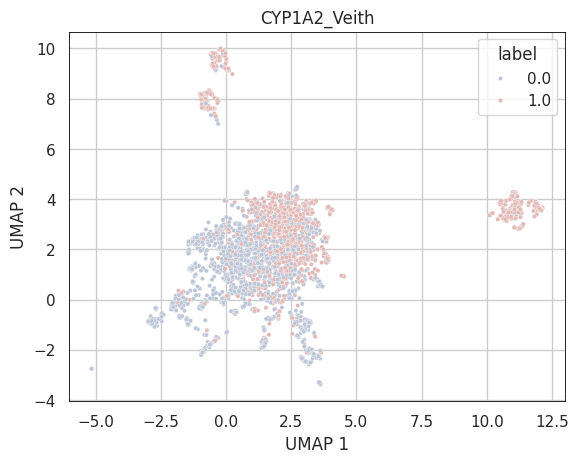

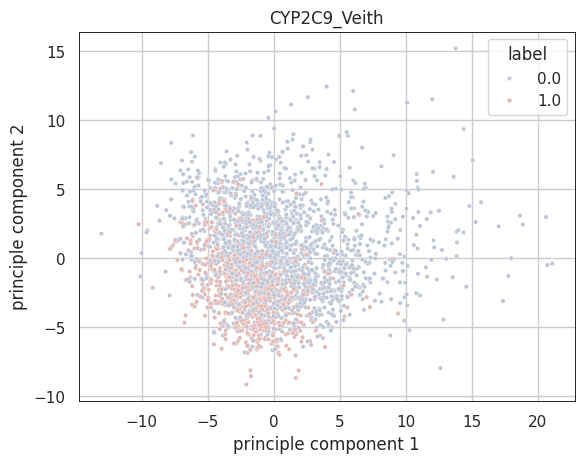

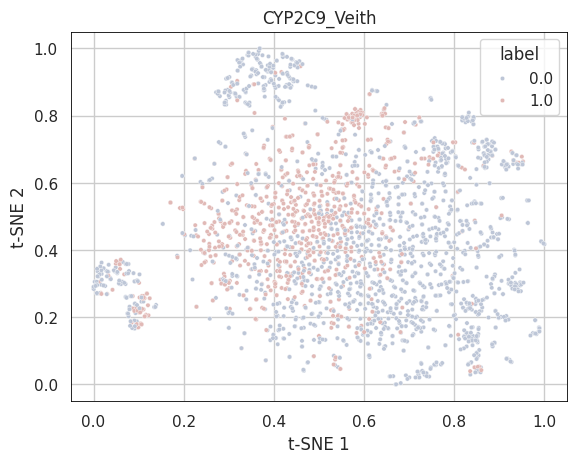

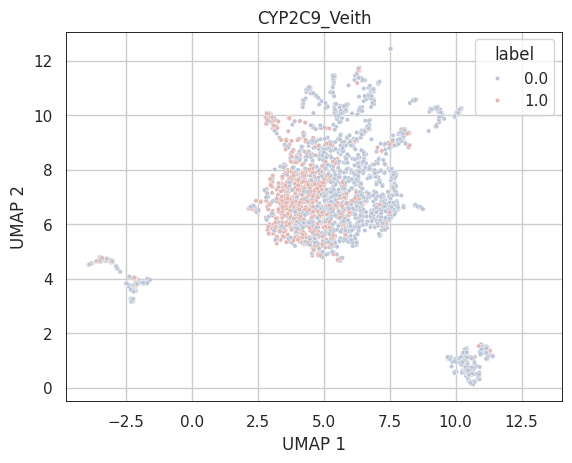

In [11]:
for name in names:
    for dim_reduct in ['PCA', 't-SNE', 'UMAP']:
        plot_dim_reduced(mu_dict[name], np.array(y_label[name]), names_dict[name],
                         dim_reduct=dim_reduct, title=f'{name}', cp=None)
